In [170]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [131]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import gzip 
import tqdm
import requests


def harmonic_sum(data, scale_factor=1, cap=None):
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """
    
    if isinstance(data, pd.Series):
    
    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum


def add_missing_efo(efo_ids):
    missing_efo_map = {}
    for efo_id in efo_ids:
        url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={efo_id}'
        r = requests.get(url)
        data = r.json()

        missing_efo_map[efo_id] = data['_embedded']['terms'][0]['label']

    return missing_efo_map
        

def add_missing_genes(genes):
    missing_gene_map = {}
    for ensembl_id in genes:
        r = requests.get(f'http://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json;expand=0')
        missing_gene_map[ensembl_id] = r.json()['display_name']
        
    return missing_gene_map


def so_lookup(so_term):
    '''
    Function to do the OLS lookup, returns with the label.
    '''
    
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={so_term}'
    r = requests.get(url)
    data = r.json()

    return data['_embedded']['terms'][0]['label']
    

def read_eva_evidences(source_file):
    
    parsed_data = []

    with gzip.open(source_file) as f:
        for line in f:
            data = json.loads(line)
            evidence = {
                'type': data['type'],
                'target': data['unique_association_fields']['gene'],
                'disease': data['unique_association_fields']['phenotype'].split('/')[-1],
                'rsid': data['unique_association_fields']['variant_id'],
                'clinvar_acces': data['unique_association_fields']['clinvarAccession'],   
            }

            if data['type'] == 'genetic_association':
                evidence.update({
                    'score': data['evidence']['variant2disease']['resource_score']['value'],
                    'star': data['evidence']['variant2disease']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['variant2disease']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['variant2disease']['clinical_significance'],
                    'so_code':  data['evidence']['gene2variant']['functional_consequence'].split('/')[-1],
                })

            elif data['type'] == 'somatic_mutation':
                evidence.update({
                    'score': data['evidence']['resource_score']['value'],
                    'star': data['evidence']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['clinical_significance'],
                    'so_code': data['evidence']['known_mutations'][0]['functional_consequence'].split('/')[-1],
                })
            parsed_data.append(evidence)

    return pd.DataFrame(parsed_data)
                    


In [21]:
# The new eva data:
eva_file = '/Users/dsuveges/project/evidences/cttv012-2020-10-21.json.gz'
eva = read_eva_evidences(eva_file)

# The gene data:
gene_id_map_df = pd.read_csv('gene_id_map.tsv.gz', sep='\t')
eva = eva.merge(gene_id_map_df, how='left', left_on='target', right_on='gene_id')

# Get non-mapped gene names:
gene_id_map = add_missing_genes(eva.loc[eva.symbol.isna()].target.unique())
eva['symbol'] = eva.apply(lambda row: row['symbol'] if not isinstance(row['symbol'], float) else gene_id_map[row['target']], axis=1)

# Generating a lookup dictionary for consequences:
so_lookup_table = {x:so_lookup(x) for x in tqdm.tqdm(eva.so_code.unique())}

# Adding consequence label:
eva['consequence'] = eva.so_code.apply(lambda so_term: so_lookup_table[so_term])

# Adding disease labels:
efo_map_df = pd.read_csv('efo_id_map.tsv.gz', sep='\t')
eva = eva.merge(efo_map_df, how='left', left_on='disease', right_on='efo_id')

# Updating missing EFOs:
efo_mapping = add_missing_efo(eva.loc[eva.label.isna()].disease.unique())
eva['label'] = eva.apply(lambda row: row['label'] if not isinstance(row['label'], float) else efo_mapping[row['disease']], axis=1)

# Saving table:
eva.to_csv('2020.10.27_eva.tsv.gz', sep='\t', index=False, compression='infer')


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


### Evidence types 

In [68]:
som_assoc = eva.loc[eva.type == 'somatic_mutation',['target','disease','type']].drop_duplicates()
gen_assoc = eva.loc[eva.type == 'genetic_association',['target','disease','type']].drop_duplicates()
merged_assoc = som_assoc.merge(gen_assoc, on=['target','disease'], how='outer',indicator=True)

print(f'Number of somatic associations: {len(som_assoc)}')
print(f'Number of genetic associations: {len(gen_assoc)}')
overlapping_assoc = len(merged_assoc.loc[merged_assoc._merge == 'both'])
print(f'Number of overlapping associations: {overlapping_assoc}')


Number of somatic associations: 1820
Number of genetic associations: 28412
Number of overlapping associations: 272


# Reading and adding positive controls

In [49]:
pharma_project_file = '/Users/dsuveges/project/issue-1166_benchmarking_clingen_evidences/abbvie_pharmaprojects_2018_mapped.csv'

# Reading pharmaproject file as dataframe:
pharma_df = pd.read_csv(pharma_project_file)

# Renaming columns for easy handling:
pharma_df.rename(columns={
    'ensembl_id': 'target',
    'id': 'disease',
    'lApprovedUS.EU': 'approved'
}, inplace=True)

print(f'Number of entries in pharmaproject: {len(pharma_df)}')
print(f'Number of disease/target associations pair: {len(pharma_df[["target","disease"]].drop_duplicates())}')
print(pharma_df.head())

Number of entries in pharmaproject: 22947
Number of disease/target associations pair: 22947
            target  approved      disease
0  ENSG00000119535     False  EFO_1001255
1  ENSG00000151617     False  EFO_1000014
2  ENSG00000012779     False  EFO_0003894
3  ENSG00000026508     False  EFO_0003894
4  ENSG00000057252     False  EFO_0003894


rows: 32570
unique associations: 20289
rows: 20289
unique associations: 20289
            target        disease  assoc_score
0  ENSG00000000938    EFO_0000668     1.138000
1  ENSG00000000938  Orphanet_1359     1.500000
2  ENSG00000000971    EFO_0000546     0.978000
3  ENSG00000000971    EFO_0001365     2.085433
4  ENSG00000000971    EFO_0003768     0.640000


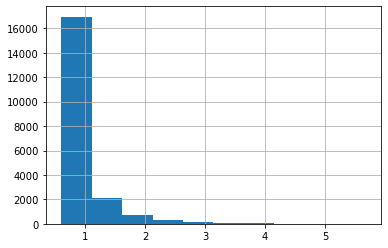

In [52]:
literature_df = pd.read_parquet('/Users/dsuveges/project/evidences/20.06_evidence_data.filtered.parquet')
literature_df.rename(columns={
    'efo_code': 'disease',
    'gene_id': 'target'
}, inplace=True)

# Applying score threshold:
literature_df = literature_df.loc[literature_df.assoc_score >= 0.6]

print(f'rows: {len(literature_df)}')
print(f'unique associations: {len(literature_df[["disease","target"]].drop_duplicates())}')


summed_data = []

for (target, disease), group in literature_df.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'assoc_score': harmonic_sum(group.assoc_score.tolist())
    }) 

literature_assoc = pd.DataFrame(summed_data)

print(f'rows: {len(literature_assoc)}')
print(f'unique associations: {len(literature_assoc[["disease","target"]].drop_duplicates())}')
print(literature_assoc.head())
literature_assoc.assoc_score.hist()


In [92]:
merged_poscon = literature_assoc.merge(pharma_df, how='outer', on=['disease','target'], indicator=True)
print(f'Number of associations found in both positive sets: {len(merged_poscon.loc[merged_poscon._merge == "both"])}')

Number of associations found in both positive sets: 1314


# Adding positive controls to eva data

In [93]:
# Renaming columns in the merged list:
merged_poscon_updated = merged_poscon.rename(columns={'assoc_score': 'literature', 'approved': 'pharmaproject'})

# Update colum values:

In [94]:
# Literature: setting all non-na values to true:
merged_poscon_updated.loc[~merged_poscon_updated.literature.isna(),'literature'] = True

# New column of the approved associations:
merged_poscon_updated.loc[merged_poscon_updated.pharmaproject == True,'pharmaproject_approved'] = True

# Pharmaproject: set all non-na values to true:
merged_poscon_updated.loc[~merged_poscon_updated.pharmaproject.isna(),'pharmaproject'] = True

# Merging with the eva data:
eva_poscon_merge = eva.merge(merged_poscon_updated[['target','disease','literature','pharmaproject','pharmaproject_approved']], on=['target','disease'], how='left')

# Update values:
eva_poscon_merge.loc[eva_poscon_merge.literature.isna(),'literature'] = False
eva_poscon_merge.loc[eva_poscon_merge.pharmaproject.isna(),'pharmaproject'] = False
eva_poscon_merge.loc[eva_poscon_merge.pharmaproject_approved.isna(),'pharmaproject_approved'] = False

# Generate combined positive control list:
eva_poscon_merge['poscon'] = False
eva_poscon_merge.loc[eva_poscon_merge.pharmaproject | eva_poscon_merge.literature, 'poscon'] = True


In [95]:
pharmap_poscon = eva_poscon_merge.loc[eva_poscon_merge.pharmaproject]
pharmap_poscon_approved = eva_poscon_merge.loc[eva_poscon_merge.pharmaproject_approved]
literature_poscon = eva_poscon_merge.loc[eva_poscon_merge.literature]
all_poscon = eva_poscon_merge.loc[eva_poscon_merge.poscon]

print(f"NUmber of poscon evidence: {len(all_poscon)}")
print(f"NUmber of poscon association: {len(all_poscon[['disease','target']].drop_duplicates())}")
print(f"NUmber of literature poscon evidence: {len(literature_poscon)}")
print(f"NUmber of literature poscon association: {len(literature_poscon[['disease','target']].drop_duplicates())}")
print(f"NUmber of pharmaproject poscon evidence: {len(pharmap_poscon)}")
print(f"NUmber of pharmaproject poscon association: {len(pharmap_poscon[['disease','target']].drop_duplicates())}")
print(f"NUmber of pharmaproject approved poscon evidence: {len(pharmap_poscon_approved)}")
print(f"NUmber of pharmaproject approved poscon association: {len(pharmap_poscon_approved[['disease','target']].drop_duplicates())}")

NUmber of poscon evidence: 41755
NUmber of poscon association: 557
NUmber of literature poscon evidence: 33396
NUmber of literature poscon association: 325
NUmber of pharmaproject poscon evidence: 12301
NUmber of pharmaproject poscon association: 310
NUmber of pharmaproject approved poscon evidence: 5799
NUmber of pharmaproject approved poscon association: 50


# Weight 1: number of evidence

The number of evidence is highly correlated with the probablilty of a disease/target association is a positive. Calculating ROC if the association score would be the number of evidence

In [135]:
# Grouping eva dataframe by disease and target and get the length for each group
s = eva_poscon_merge.groupby(['disease','target']).apply(len)
s.name = 'evidence_count'

# Grouping eva dataframe to get disease/target positive control list:
poscon = eva_poscon_merge.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
evidence_count = pd.concat([s,poscon], axis=1)

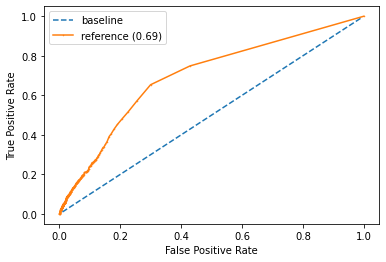

In [136]:
# Variant count only:
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(evidence_count.positive_control, evidence_count.evidence_count)
auc_varcnt = roc_auc_score(evidence_count.positive_control, evidence_count.evidence_count)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'reference ({auc_varcnt:.2})') # variant count

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

# Weighting variant consequence 

In [151]:
eva_consequences_order_map = {
    'downstream_gene_variant': 0.6,
    'upstream_gene_variant': 0.6,
    'intron_variant': 0.65,
    'non_coding_transcript_exon_variant': 0.65,
    '3_prime_UTR_variant': 0.65,
    '5_prime_UTR_variant': 0.65,
    'mature_miRNA_variant': 0.65,
    'coding_sequence_variant': 0.95,
    'synonymous_variant': 0.65,
    'stop_retained_variant': 0.65,
    'incomplete_terminal_codon_variant': 0.9,
    'splice_region_variant': 0.9,
    'protein_altering_variant': 0.7,
    'missense_variant': 0.7,
    'inframe_deletion': 0.7,
    'inframe_insertion': 0.7,
    'start_lost': 0.95,
    'stop_lost': 0.9,
    'frameshift_variant': 0.95,
    'stop_gained': 0.95,
    'splice_donor_variant': 0.95,
    'splice_acceptor_variant': 0.95,
    'trinucleotide_repeat_expansion': 1,
    'short_tandem_repeat_expansion': 1,
    'transcript_ablation':1
}

# Review status is an ordinal variable. Mapping to numbers:
review_status_order_map = {
    'no assertion provided': 1/7,
    'no assertion criteria provided': 2/7,
    'criteria provided, conflicting interpretations': 3/7,
    'criteria provided, single submitter': 4/7,
    'criteria provided, multiple submitters, no conflicts': 5/7,
    'reviewed by expert panel': 6/7,
    'practice guideline': 7/7
}

clinical_significance_mapping = {
    'association not found': 0,  
    'benign': 0,
    'not provided': 0,
    'uncertain significance': 0.01,    
    'likely benign': 0.2,    
    'conflicting interpretations of pathogenicity': 0.3,   
    'other': 0.3,
    'association': 0.5,
    'drug response': 1,
    'protective':1,
    'affects': 0.7,
    'likely pathogenic' : 0.8,
    'risk factor': 0.8,
    'pathogenic' : 1,
}

simplified_evid = eva_poscon_merge[['target','disease','consequence','poscon','review_status']].copy()
simplified_evid['consequence_weighted'] = simplified_evid.consequence.map(eva_consequences_order_map)
simplified_evid['review_weighted'] = simplified_evid.review_status.map(review_status_order_map)

simplified_evid.head()

,target,disease,consequence,poscon,review_status,consequence_weighted,review_weighted
0,ENSG00000154803,Orphanet_2903,frameshift_variant,False,no assertion criteria provided,0.95,0.285714
1,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857
2,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857
3,ENSG00000103197,Orphanet_805,inframe_deletion,False,no assertion provided,0.70,0.142857
4,ENSG00000129422,EFO_0002950,splice_acceptor_variant,False,no assertion provided,0.95,0.142857


In [154]:
# Grouping eva dataframe by disease and target and get the length for each group
cons_weight = simplified_evid.groupby(['disease','target']).consequence_weighted.agg(harmonic_sum)
cons_weight.name = 'consequence_weighted'

# Grouping eva dataframe to get disease/target positive control list:
poscon = simplified_evid.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
consequence_weighted = pd.concat([cons_weight,poscon], axis=1)


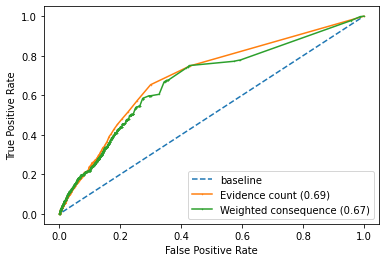

In [155]:
# Variant count only:
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(evidence_count.positive_control, evidence_count.evidence_count)
auc_varcnt = roc_auc_score(evidence_count.positive_control, evidence_count.evidence_count)

# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)
auc_cons_weight = roc_auc_score(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'Evidence count ({auc_varcnt:.2})') # variant count
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

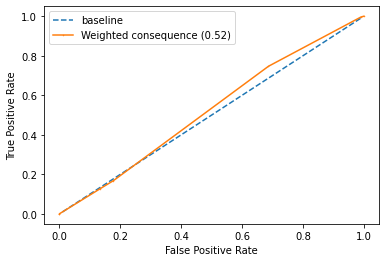

In [160]:
# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.consequence_weighted)
auc_cons_weight = roc_auc_score(simplified_evid.poscon, simplified_evid.consequence_weighted)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

In [157]:
simplified_evid.head()

,target,disease,consequence,poscon,review_status,consequence_weighted,review_weighted
0,ENSG00000154803,Orphanet_2903,frameshift_variant,False,no assertion criteria provided,0.95,0.285714
1,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857
2,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857
3,ENSG00000103197,Orphanet_805,inframe_deletion,False,no assertion provided,0.70,0.142857
4,ENSG00000129422,EFO_0002950,splice_acceptor_variant,False,no assertion provided,0.95,0.142857


# Weighting by review status

In [163]:
# Grouping eva dataframe by disease and target and get the length for each group
rew_weight = simplified_evid.groupby(['disease','target']).review_weighted.agg(harmonic_sum)
rew_weight.name = 'review_status_weighted'

# Grouping eva dataframe to get disease/target positive control list:
poscon = simplified_evid.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
review_status_weighted = pd.concat([rew_weight,poscon], axis=1)


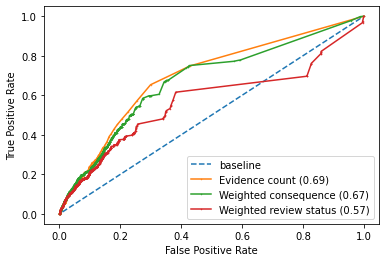

In [164]:
# Variant count only:
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(evidence_count.positive_control, evidence_count.evidence_count)
auc_varcnt = roc_auc_score(evidence_count.positive_control, evidence_count.evidence_count)

# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)
auc_cons_weight = roc_auc_score(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)

# Weighted review status:
fpr_review_stat, tpr_review_stat, thresholds = roc_curve(review_status_weighted.positive_control, review_status_weighted.review_status_weighted)
auc_review_stat = roc_auc_score(review_status_weighted.positive_control, review_status_weighted.review_status_weighted)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'Evidence count ({auc_varcnt:.2})') # variant count
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence
pyplot.plot(fpr_review_stat, tpr_review_stat, marker='.', markersize = 1, label=f'Weighted review status ({auc_review_stat:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

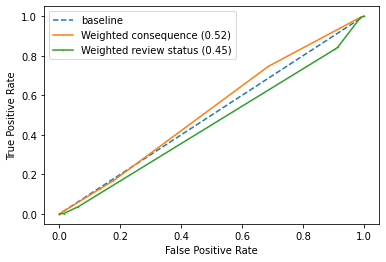

In [165]:
# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.consequence_weighted)
auc_cons_weight = roc_auc_score(simplified_evid.poscon, simplified_evid.consequence_weighted)

# Weighted review status:
fpr_rev, tpr_rev, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.review_weighted)
auc_rev = roc_auc_score(simplified_evid.poscon, simplified_evid.review_weighted)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence
pyplot.plot(fpr_rev, tpr_rev, marker='.', markersize = 1, label=f'Weighted review status ({auc_rev:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:

pyplot.legend()

# Weighting by clinical significance

## 1. Manually assign weights to terms


In [167]:
clinical_significance_mapping = {
    'association not found': 0,  
    'benign': 0,
    'not provided': 0,
    'uncertain significance': 0,    
    'likely benign': 0.2,    
    'conflicting interpretations of pathogenicity': 0.3,   
    'other': 0.3,
    'association': 0.5,
    'drug response': 0.5,
    'protective':0.5,
    'affects': 0.7,
    'likely pathogenic' : 0.8,
    'risk factor': 0.8,
    'pathogenic' : 1,
}

simplified_evid['clinical_significance_weighted'] = eva.clinical_significance.apply(lambda y: max([x for x in map(lambda x: clinical_significance_mapping[x], y)]))
simplified_evid.head()

,target,disease,consequence,poscon,review_status,consequence_weighted,review_weighted,clinical_significance_weighted
0,ENSG00000154803,Orphanet_2903,frameshift_variant,False,no assertion criteria provided,0.95,0.285714,1.0
1,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0
2,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0
3,ENSG00000103197,Orphanet_805,inframe_deletion,False,no assertion provided,0.70,0.142857,0.0
4,ENSG00000129422,EFO_0002950,splice_acceptor_variant,False,no assertion provided,0.95,0.142857,0.0


In [168]:
# Grouping eva dataframe by disease and target and get the length for each group
rew_weight = simplified_evid.groupby(['disease','target']).clinical_significance_weighted.agg(harmonic_sum)
rew_weight.name = 'clinical_significance_weighted'

# Grouping eva dataframe to get disease/target positive control list:
poscon = simplified_evid.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
clinical_significance_weighted = pd.concat([rew_weight,poscon], axis=1)


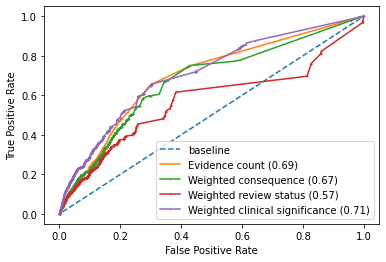

In [172]:
# Variant count only:
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(evidence_count.positive_control, evidence_count.evidence_count)
auc_varcnt = roc_auc_score(evidence_count.positive_control, evidence_count.evidence_count)

# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)
auc_cons_weight = roc_auc_score(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)

# Weighted review status:
fpr_review_stat, tpr_review_stat, thresholds = roc_curve(review_status_weighted.positive_control, review_status_weighted.review_status_weighted)
auc_review_stat = roc_auc_score(review_status_weighted.positive_control, review_status_weighted.review_status_weighted)

# Weighted clinical significance:
fpr_clin_sig, tpr_clin_sig, thresholds = roc_curve(clinical_significance_weighted.positive_control, clinical_significance_weighted.clinical_significance_weighted)
auc_clin_sig = roc_auc_score(clinical_significance_weighted.positive_control, clinical_significance_weighted.clinical_significance_weighted)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'Evidence count ({auc_varcnt:.2})') # variant count
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence
pyplot.plot(fpr_review_stat, tpr_review_stat, marker='.', markersize = 1, label=f'Weighted review status ({auc_review_stat:.2})') # weighted consequence
pyplot.plot(fpr_clin_sig, tpr_clin_sig, marker='.', markersize = 1, label=f'Weighted clinical significance ({auc_clin_sig:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

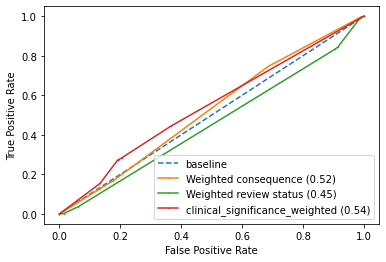

In [173]:
# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.consequence_weighted)
auc_cons_weight = roc_auc_score(simplified_evid.poscon, simplified_evid.consequence_weighted)

# Weighted review status:
fpr_rev, tpr_rev, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.review_weighted)
auc_rev = roc_auc_score(simplified_evid.poscon, simplified_evid.review_weighted)


# Weighted clinical significance:
fpr_clin_sig, tpr_clin_sig, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.clinical_significance_weighted)
auc_clin_sig = roc_auc_score(simplified_evid.poscon, simplified_evid.clinical_significance_weighted)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence
pyplot.plot(fpr_rev, tpr_rev, marker='.', markersize = 1, label=f'Weighted review status ({auc_rev:.2})') # weighted consequence
pyplot.plot(fpr_clin_sig, tpr_clin_sig, marker='.', markersize = 1, label=f'clinical_significance_weighted ({auc_clin_sig:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:

pyplot.legend()

## 2. Optimize clinical significance weights

In [202]:
# Get unique clinical significance values:
clin_sig = eva_poscon_merge[['target','disease','poscon','clinical_significance']].copy()
clin_sig['clinical_signif'] = clin_sig.clinical_significance.apply(lambda x: x[0] if len(x) == 1 else None)

# Generate dummy features from clinical significance values:
clin_sig = pd.get_dummies(clin_sig, prefix='clin_sig', columns=['clinical_signif'])

# Update dummy columns were more then one clinical significance value is available:
for i, row in clin_sig.loc[clin_sig.clinical_significance.apply(lambda x: True if len(x)>1 else False)].iterrows():
    for sig_val in row['clinical_significance']:
        clin_sig.loc[i,f'clin_sig_{sig_val}'] = 1
        
        
clin_sig.loc[clin_sig.clinical_significance.apply(lambda x: True if len(x)>1 else False)].head()

,target,disease,poscon,clinical_significance,clin_sig_affects,clin_sig_association,clin_sig_association not found,clin_sig_benign,clin_sig_conflicting interpretations of pathogenicity,clin_sig_drug response,clin_sig_likely benign,clin_sig_likely pathogenic,clin_sig_not provided,clin_sig_other,clin_sig_pathogenic,clin_sig_protective,clin_sig_risk factor,clin_sig_uncertain significance
150,ENSG00000110711,EFO_1000478,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
151,ENSG00000110711,EFO_1000478,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
1633,ENSG00000119899,Orphanet_309334,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
2084,ENSG00000156709,Orphanet_139583,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
2085,ENSG00000156709,Orphanet_139583,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [204]:
# Build classifier:
rf = RandomForestClassifier()
columns = [x for x in clin_sig.columns if 'clin_sig_' in x]
rf.fit(clin_sig[columns],clin_sig.poscon)  

# Extracting weight:
print('Extract weights...')
weight_series = pd.Series(rf.feature_importances_, index=columns)
print(weight_series)



Extract weights...
clin_sig_affects                                         0.002393
clin_sig_association                                     0.000809
clin_sig_association not found                           0.000057
clin_sig_benign                                          0.096594
clin_sig_conflicting interpretations of pathogenicity    0.006570
clin_sig_drug response                                   0.002241
clin_sig_likely benign                                   0.031695
clin_sig_likely pathogenic                               0.635208
clin_sig_not provided                                    0.020524
clin_sig_other                                           0.026147
clin_sig_pathogenic                                      0.064453
clin_sig_protective                                      0.007841
clin_sig_risk factor                                     0.026260
clin_sig_uncertain significance                          0.079207
dtype: float64


In [205]:
# Updating all values with weights:
for col,weight in weight_series.iteritems():
    clin_sig[col] = clin_sig[col]*weight
    
clin_sig['weighted_clin_sig'] = clin_sig[columns].apply(max, axis=1)

In [206]:
# Grouping eva dataframe by disease and target and get the length for each group
weighted_clin_sig = clin_sig.groupby(['disease','target']).weighted_clin_sig.agg(harmonic_sum)
weighted_clin_sig.name = 'clin_sig'

# Grouping eva dataframe to get disease/target positive control list:
poscon = clin_sig.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
weighted_clin_sig = pd.concat([weighted_clin_sig,poscon], axis=1)
weighted_clin_sig.head()

clin_sig  positive_control
disease     target                                     
EFO_0000095 ENSG00000010671  0.020524              True
            ENSG00000082898  1.164549              True
            ENSG00000087365  0.952813             False
            ENSG00000109670  1.860505             False
            ENSG00000115524  1.556261              True

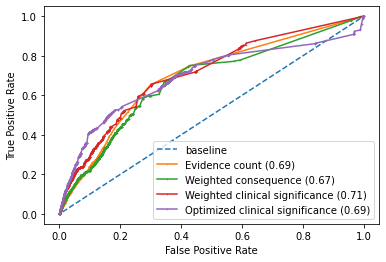

In [208]:
# Variant count only:
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(evidence_count.positive_control, evidence_count.evidence_count)
auc_varcnt = roc_auc_score(evidence_count.positive_control, evidence_count.evidence_count)

# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)
auc_cons_weight = roc_auc_score(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)

# Weighted clinical significance:
fpr_clin_sig, tpr_clin_sig, thresholds = roc_curve(clinical_significance_weighted.positive_control, clinical_significance_weighted.clinical_significance_weighted)
auc_clin_sig = roc_auc_score(clinical_significance_weighted.positive_control, clinical_significance_weighted.clinical_significance_weighted)

# optimized clinical significance:
fpr_clin_opt, tpr_clin_opt, thresholds = roc_curve(weighted_clin_sig.positive_control, weighted_clin_sig.clin_sig)
auc_clin_opt = roc_auc_score(weighted_clin_sig.positive_control, weighted_clin_sig.clin_sig)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'Evidence count ({auc_varcnt:.2})') # variant count
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence
pyplot.plot(fpr_clin_sig, tpr_clin_sig, marker='.', markersize = 1, label=f'Weighted clinical significance ({auc_clin_sig:.2})') # weighted consequence
pyplot.plot(fpr_clin_opt, tpr_clin_opt, marker='.', markersize = 1, label=f'Optimized clinical significance ({auc_clin_opt:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

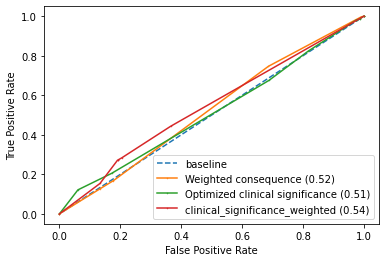

In [212]:
# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.consequence_weighted)
auc_cons_weight = roc_auc_score(simplified_evid.poscon, simplified_evid.consequence_weighted)

# Weighted clinical significance:
fpr_clin_opt, tpr_clin_opt, thresholds = roc_curve(clin_sig.poscon, clin_sig.weighted_clin_sig)
auc_clin_opt = roc_auc_score(clin_sig.poscon, clin_sig.weighted_clin_sig)

# Weighted clinical significance:
fpr_clin_sig, tpr_clin_sig, thresholds = roc_curve(simplified_evid.poscon, simplified_evid.clinical_significance_weighted)
auc_clin_sig = roc_auc_score(simplified_evid.poscon, simplified_evid.clinical_significance_weighted)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence
pyplot.plot(fpr_clin_opt, tpr_clin_opt, marker='.', markersize = 1, label=f'Optimized clinical significance ({auc_clin_opt:.2})') # weighted consequence
pyplot.plot(fpr_clin_sig, tpr_clin_sig, marker='.', markersize = 1, label=f'clinical_significance_weighted ({auc_clin_sig:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:

pyplot.legend()

# Combining all scores - random forest to get weights

In [224]:
# Combining into new dataframe:
simplified_evid['clinical_significance_optimized'] = clin_sig.weighted_clin_sig

# Build classifier:
rf = RandomForestClassifier()
columns = ['consequence_weighted','review_weighted','clinical_significance_optimized']
rf.fit(simplified_evid[columns],simplified_evid.poscon)  

# Extracting weight:
print('Extract weights...')
weight_series = pd.Series(rf.feature_importances_, index=columns)
print(weight_series)



Extract weights...
consequence_weighted               0.170692
review_weighted                    0.361356
clinical_significance_optimized    0.467952
dtype: float64


In [235]:
# Generate evidence score:
def calculate_evidence_score(row):
    score = 0
    for col in columns:
        score += row[col]*weight_series[col]
        
    return score


simplified_evid['evidence_score'] = simplified_evid.apply(calculate_evidence_score, axis=1)
simplified_evid.head()

KeyboardInterrupt: 

In [226]:
# Grouping eva dataframe by disease and target and get the length for each group
combined_scores = simplified_evid.groupby(['disease','target']).combined_score.agg(harmonic_sum)
combined_scores.name = 'combined_scores'

# Grouping eva dataframe to get disease/target positive control list:
poscon = simplified_evid.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
combined_scores_df = pd.concat([combined_scores,poscon], axis=1)
combined_scores.head()

disease      target         
EFO_0000095  ENSG00000010671    0.180711
             ENSG00000082898    0.953289
             ENSG00000087365    0.779964
             ENSG00000109670    1.522993
             ENSG00000115524    1.273941
Name: combined_scores, dtype: float64

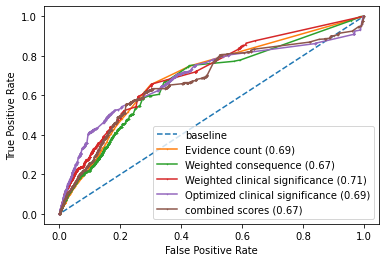

In [227]:
# Variant count only:
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(evidence_count.positive_control, evidence_count.evidence_count)
auc_varcnt = roc_auc_score(evidence_count.positive_control, evidence_count.evidence_count)

# Weighted consequences:
fpr_cons_weight, tpr_cons_weight, thresholds = roc_curve(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)
auc_cons_weight = roc_auc_score(consequence_weighted.positive_control, consequence_weighted.consequence_weighted)

# Weighted clinical significance:
fpr_clin_sig, tpr_clin_sig, thresholds = roc_curve(clinical_significance_weighted.positive_control, clinical_significance_weighted.clinical_significance_weighted)
auc_clin_sig = roc_auc_score(clinical_significance_weighted.positive_control, clinical_significance_weighted.clinical_significance_weighted)

# optimized clinical significance:
fpr_clin_opt, tpr_clin_opt, thresholds = roc_curve(weighted_clin_sig.positive_control, weighted_clin_sig.clin_sig)
auc_clin_opt = roc_auc_score(weighted_clin_sig.positive_control, weighted_clin_sig.clin_sig)

# combined scores:
fpr_com, tpr_com, thresholds = roc_curve(combined_scores_df.positive_control, combined_scores_df.combined_scores)
auc_com = roc_auc_score(combined_scores_df.positive_control, combined_scores_df.combined_scores)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'Evidence count ({auc_varcnt:.2})') # variant count
pyplot.plot(fpr_cons_weight, tpr_cons_weight, marker='.', markersize = 1, label=f'Weighted consequence ({auc_cons_weight:.2})') # weighted consequence
pyplot.plot(fpr_clin_sig, tpr_clin_sig, marker='.', markersize = 1, label=f'Weighted clinical significance ({auc_clin_sig:.2})') # weighted consequence
pyplot.plot(fpr_clin_opt, tpr_clin_opt, marker='.', markersize = 1, label=f'Optimized clinical significance ({auc_clin_opt:.2})') # weighted consequence
pyplot.plot(fpr_com, tpr_com, marker='.', markersize = 1, label=f'combined scores ({auc_com:.2})') # weighted consequence


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

In [229]:
simplified_evid.head()

,target,disease,consequence,poscon,review_status,consequence_weighted,review_weighted,clinical_significance_weighted,clinical_significance_optimized,combined_score
0,ENSG00000154803,Orphanet_2903,frameshift_variant,False,no assertion criteria provided,0.95,0.285714,1.0,0.064453,0.295563
1,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0,0.020524,0.223384
2,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0,0.020524,0.223384
3,ENSG00000103197,Orphanet_805,inframe_deletion,False,no assertion provided,0.70,0.142857,0.0,0.020524,0.180711
4,ENSG00000129422,EFO_0002950,splice_acceptor_variant,False,no assertion provided,0.95,0.142857,0.0,0.020524,0.223384


In [233]:
eva_poscon_merge.head()

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,gene_id,symbol,consequence,efo_id,label,literature,pharmaproject,pharmaproject_approved,poscon
0,genetic_association,ENSG00000154803,Orphanet_2903,rs886037610,RCV000003542,1.000000e-07,0,no assertion criteria provided,[pathogenic],SO_0001589,ENSG00000154803,FLCN,frameshift_variant,Orphanet_2903,Familial spontaneous pneumothorax,False,False,False,False
1,genetic_association,ENSG00000103197,Orphanet_805,rs137854012,RCV000042664,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,ENSG00000103197,TSC2,frameshift_variant,Orphanet_805,Tuberous sclerosis,False,False,False,False
2,genetic_association,ENSG00000103197,Orphanet_805,rs137854007,RCV000042927,1.000000e-07,0,no assertion provided,[not provided],SO_0001589,ENSG00000103197,TSC2,frameshift_variant,Orphanet_805,Tuberous sclerosis,False,False,False,False
3,genetic_association,ENSG00000103197,Orphanet_805,rs397515245,RCV000055557,1.000000e-07,0,no assertion provided,[not provided],SO_0001822,ENSG00000103197,TSC2,inframe_deletion,Orphanet_805,Tuberous sclerosis,False,False,False,False
4,genetic_association,ENSG00000129422,EFO_0002950,rs1554507029,RCV000161533,1.000000e-07,0,no assertion provided,[not provided],SO_0001574,ENSG00000129422,MTUS1,splice_acceptor_variant,EFO_0002950,pregnancy,False,False,False,False


In [234]:
eva_poscon_merge.to_parquet('EVA_processed_2020.10.25.parquet')

In [ ]:
import ~.repositorGenomePlo